In [1]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt

%matplotlib inline  

In [2]:
net=pf.Network()
net.load('PFNET-multi_period/data/ieee14.mat')

In [3]:
# Problem set up

total_load = sum([l.P for l in net.loads])
# uncertainty = 100.*sum([g.P_std for g in net.var_generators])/sum([g.P_max for g in net.var_generators])
corr_value = net.vargen_corr_value+0.5
corr_radius = net.vargen_corr_radius

for br in net.branches:
    br.ratingA = 1e10

for gen in net.generators:
    gen.P_min = 0.
    gen.P_max = np.maximum(gen.P_max,0.)
    assert(gen.P_min <= gen.P_max)


num_w = net.num_buses-net.get_num_slack_buses() # voltage angles
num_p = net.get_num_P_adjust_gens()             #net.get_num_generators()         # adjustable generators
# num_r = net.num_vargens                         # renewable generators
num_bus = net.num_buses                         # buses
num_br = net.num_branches                       # branches


In [4]:
net.clear_flags()
net.set_flags(pf.OBJ_BUS,
              pf.FLAG_VARS,
              pf.BUS_PROP_NOT_SLACK,
              pf.BUS_VAR_VANG)
net.set_flags(pf.OBJ_GEN,
              pf.FLAG_VARS,
              pf.GEN_PROP_P_ADJUST,
              pf.GEN_VAR_P)

In [5]:
x = net.get_var_values()
Pw = net.get_var_projection(pf.OBJ_BUS,pf.BUS_VAR_VANG)
Pp = net.get_var_projection(pf.OBJ_GEN,pf.GEN_VAR_P)


In [6]:
pf_eq = pf.Constraint(pf.CONSTR_TYPE_DCPF,net)
pf_eq.analyze()
pf_eq.eval(x)
AA = pf_eq.A.copy()
bb = pf_eq.b.copy()

In [7]:
fl_lim = pf.Constraint(pf.CONSTR_TYPE_DC_FLOW_LIM,net)
fl_lim.analyze()
fl_lim.eval(x)
GG = fl_lim.G.copy()
hl = fl_lim.l.copy()
hu = fl_lim.u.copy()

In [8]:
cost = pf.Function(pf.FUNC_TYPE_GEN_COST,1.,net)
cost.analyze()
cost.eval(x)
H = (cost.Hphi + cost.Hphi.T - triu(cost.Hphi))/net.base_power # symmetric
g = cost.gphi/net.base_power - H*x
l = net.get_var_values(pf.LOWER_LIMITS)
u = net.get_var_values(pf.UPPER_LIMITS)

In [9]:
p_max = Pp*u
p_min = Pp*l
w_max = 1e6*np.ones(num_w)
w_min = -1e6*np.ones(num_w)
#r_max = Pr*u
#r_base = Pr*x
z_max = hu
z_min = hl 
H0 = Pp*H*Pp.T
g0 = Pp*g
#H1 = self.H0*self.parameters['cost_factor']
g1 = np.zeros(num_p)
G = AA*Pp.T
#R = AA*Pr.T
A = -AA*Pw.T
J = GG*Pw.T  # check
b = bb


In [10]:
from cvxpy import *
import mosek
import gurobi

In [11]:
n_h=24
p=Variable(num_p,n_h)
w=Variable(num_w,n_h)
z=Variable(num_br,n_h)
on_off=Bool(num_p,n_h)
load=Variable(num_bus,n_h)
Pforecast=total_load
Load_Penalty=1e10
OnOffCost=np.ones([1,num_p])*0.5
p_min=np.ones([1,num_p])*0.9
minup=np.ones([1,num_p])*10 #[5,10,20,3,5]
rampup=np.ones([1,num_p])*1
rampdown=np.ones([1,num_p])*1


In [12]:
b=[]
b=np.zeros([num_bus,n_h])
for i in range (n_h):
    b[:,i]=bb+0.1*np.sin(i*2*np.pi/24)

In [13]:
Constraints=[]
for i in range (n_h):
    
    Constraints.append(G*p[:,i]-A*w[:,i]==load[:,i])
    Constraints.append(J*w[:,i]==z[:,i])
    Constraints.append(w[:,i]<=1)
    Constraints.append(w[:,i]>=-1)
    Constraints.append(z[:,i]<=1)
    Constraints.append(z[:,i]>=-1)
#     Constraints.append(load[:,i]>=0)
#     Constraints.append(load[:,i]<=b[:,i])
    

for i in range(n_h):
    for j in range (num_p):
        Constraints.append(p[j,i]<=p_max[j]*on_off[j,i])
        Constraints.append(p[j,i]>=p_min[0][j]*on_off[j,i])
    

In [14]:
for i in range(1,n_h):
    for j in range (num_p):
        Constraints.append(p[j,i]-p[j,i-1]<=rampup[0][j])
        Constraints.append(p[j,i]-p[j,i-1]>=-rampdown[0][j])

In [20]:
minup

array([[ 10.,  10.,  10.,  10.,  10.]])

In [15]:
for i in range(1,n_h):
    for j in range (num_p):
        indi=(on_off[j,i] - on_off[j,i-1])
        rang= range(i,min(n_h,int(i+minup[0][j]-1)))
        Constraints.append(on_off[j,rang]>=indi)

In [16]:
Objective=0
for i in range (n_h):
    Objective=Objective + quad_form(p[:,i],H0)
    Objective=Objective + g0*p[:,i]
    Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i])
    
    

In [17]:
for i in range(1,n_h):
    for j in range (num_p):
        Objective=Objective + np.max(on_off[j,i] - on_off[j,i-1],0)*OnOffCost[0][j]

In [19]:
minup[0]

array([ 10.,  10.,  10.,  10.,  10.])

In [50]:
prob = []
prob = Problem(Minimize(Objective), Constraints)

In [51]:
prob.solve(solver=GUROBI)

1068181231.7905595

In [52]:
on_off.value

matrix([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.]])

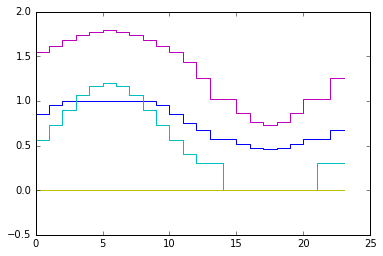

In [42]:
for i in range (num_p):
    plt.step(range(n_h),np.squeeze(np.asarray(p.value[i,:])))

plt.step(range(n_h),np.squeeze(np.asarray((sum((load.value-b))))))